# ETL and Visualization of Senators Data
This notebook demonstrates the Extract, Transform, Load (ETL) process for a dataset containing information about US Senators. We'll extract data from a JSON file, transform it into appropriate Python data structures, explore and clean the data, create visualizations, and demonstrate anonymization techniques.
The dataset contains information about 100 US Senators, including their personal details, party affiliations, contact information, and terms of service.


## Setup and Data Loading

### Import Required Libraries

In [29]:
# Data manipulation libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the style for matplotlib visualizations
sns.set(style="whitegrid")
plt.style.use('ggplot')

# Display plots inline in the notebook
%matplotlib inline

### ETL Functions - Extract

In [32]:
def load_json_data(file_path):
    """
    Load JSON data from a file.
    
    Parameters:
    file_path (str): Path to the JSON file
    
    Returns:
    dict: Loaded JSON data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Successfully loaded data from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

### ETL Functions - Transform

In [36]:
def transform_senators_data(json_data):
    """
    Transform nested JSON data into a flat pandas DataFrame.
    
    Parameters:
    json_data (dict): JSON data containing senator information
    
    Returns:
    pd.DataFrame: Flattened DataFrame of senator information
    """
    # Extract objects list from JSON
    senators = json_data['objects']
    
    # Initialize list to store flattened data
    flattened_data = []
    
    # Process each senator
    for senator in senators:
        # Create a copy of the senator dict
        senator_data = senator.copy()
        
        # Extract nested person data
        person = senator_data.pop('person', {})
        
        # Flatten person data with prefix to avoid column name conflicts
        for key, value in person.items():
            senator_data[f'person_{key}'] = value
        
        # Handle nested extra data
        extra = senator_data.pop('extra', {})
        for key, value in extra.items():
            senator_data[f'extra_{key}'] = value
            
        flattened_data.append(senator_data)
    
    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    
    print(f"Transformed data into DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

### ETL Functions - Clean

In [39]:
def clean_senators_data(df):
    """
    Clean and preprocess the senators DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    pd.DataFrame: Cleaned DataFrame
    """
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Convert date columns to datetime
    date_columns = ['startdate', 'enddate', 'person_birthday']
    for col in date_columns:
        if col in cleaned_df.columns:
            cleaned_df[col] = pd.to_datetime(cleaned_df[col], errors='coerce')
    
    # Calculate age
    if 'person_birthday' in cleaned_df.columns:
        today = pd.Timestamp.today()
        cleaned_df['age'] = (today - cleaned_df['person_birthday']).dt.days // 365
    
    # Calculate term length in years
    if 'startdate' in cleaned_df.columns and 'enddate' in cleaned_df.columns:
        cleaned_df['term_length_years'] = (cleaned_df['enddate'] - cleaned_df['startdate']).dt.days / 365.25
    
    # Create full name column
    if all(col in cleaned_df.columns for col in ['person_firstname', 'person_lastname']):
        cleaned_df['full_name'] = cleaned_df['person_firstname'] + ' ' + cleaned_df['person_lastname']
    
    print(f"Cleaning complete. DataFrame now has {cleaned_df.shape[0]} rows and {cleaned_df.shape[1]} columns")
    return cleaned_df

### Load the Data

In [41]:
# Load the senators.json file
file_path = 'senators.json'
senators_json = load_json_data(file_path)

# Transform the JSON data into a pandas DataFrame
senators_df = transform_senators_data(senators_json)

# Clean and preprocess the data
cleaned_senators_df = clean_senators_data(senators_df)

# Display the first few rows of the cleaned data
cleaned_senators_df.head()

Successfully loaded data from senators.json
Transformed data into DataFrame with 100 rows and 45 columns
Cleaning complete. DataFrame now has 100 rows and 48 columns


,caucus,congress_numbers,current,description,district,enddate,leadership_title,party,phone,role_type,...,extra_address,extra_contact_form,extra_office,extra_rss_url,extra_fax,extra_how,extra_end-type,age,term_length_years,full_name
0,None,"[117, 118, 119]",True,Senior Senator for Maine,None,2027-01-03,None,Republican,202-224-2523,senator,...,413 Dirksen Senate Office Building Washington ...,https://www.collins.senate.gov/contact,413 Dirksen Senate Office Building,http://www.collins.senate.gov/public/?a=rss.feed,NaN,NaN,NaN,72,5.998631,Susan Collins
1,None,"[117, 118, 119]",True,Senior Senator for Texas,None,2027-01-03,None,Republican,202-224-2934,senator,...,517 Hart Senate Office Building Washington DC ...,https://www.cornyn.senate.gov/contact,517 Hart Senate Office Building,http://www.cornyn.senate.gov/public/?a=rss.feed,NaN,NaN,NaN,73,5.998631,John Cornyn
2,None,"[117, 118, 119]",True,Senior Senator for Illinois,None,2027-01-03,None,Democrat,202-224-2152,senator,...,711 Hart Senate Office Building Washington DC ...,https://www.durbin.senate.gov/contact/,711 Hart Senate Office Building,http://durbin.senate.gov/public/index.cfm/rss/...,NaN,NaN,NaN,80,5.998631,Richard Durbin
3,None,"[117, 118, 119]",True,Senior Senator for South Carolina,None,2027-01-03,None,Republican,202-224-5972,senator,...,211 Russell Senate Office Building Washington ...,https://www.lgraham.senate.gov/public/index.cf...,211 Russell Senate Office Building,http://www.lgraham.senate.gov/public/index.cfm...,NaN,NaN,NaN,69,5.998631,Lindsey Graham
4,None,"[117, 118, 119]",True,Senior Senator for Kentucky,None,2027-01-03,None,Republican,202-224-2541,senator,...,317 Russell Senate Office Building Washington ...,https://www.mcconnell.senate.gov/public/index....,317 Russell Senate Office Building,http://www.mcconnell.senate.gov/public/?a=rss....,NaN,NaN,NaN,83,5.998631,Mitch McConnell


## Exploratory Data Analysis

### Basic Data Overview

In [45]:
# Get basic information about the DataFrame
print("DataFrame Info:")
cleaned_senators_df.info()

# Check for missing values
print("\nMissing Values:")
missing_values = cleaned_senators_df.isnull().sum()
print(missing_values[missing_values > 0])  # Only show columns with missing values

# Get summary statistics for numerical columns
print("\nSummary Statistics:")
cleaned_senators_df.describe()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   caucus                      2 non-null      object        
 1   congress_numbers            100 non-null    object        
 2   current                     100 non-null    bool          
 3   description                 100 non-null    object        
 4   district                    0 non-null      object        
 5   enddate                     100 non-null    datetime64[ns]
 6   leadership_title            0 non-null      object        
 7   party                       100 non-null    object        
 8   phone                       100 non-null    object        
 9   role_type                   100 non-null    object        
 10  role_type_label             100 non-null    object        
 11  senator_class               100 non-null   

,enddate,startdate,person_birthday,person_cspanid,age,term_length_years
count,100,100,100,7.800000e+01,100.000000,100.000000
mean,2029-01-02 16:04:48,2023-02-08 21:50:24,1960-12-30 10:48:00,6.791037e+05,63.800000,5.899411
min,2027-01-03 00:00:00,2021-01-03 00:00:00,1933-09-17 00:00:00,2.600000e+02,38.000000,2.160164
25%,2027-01-03 00:00:00,2021-01-03 00:00:00,1952-07-09 18:00:00,3.942700e+04,55.000000,5.998631
50%,2029-01-03 00:00:00,2023-01-03 00:00:00,1959-12-27 00:00:00,8.879500e+04,64.500000,5.998631
75%,2031-01-03 00:00:00,2025-01-03 00:00:00,1969-05-18 18:00:00,1.020023e+06,72.000000,6.001369
max,2031-01-03 00:00:00,2025-01-21 00:00:00,1987-02-16 00:00:00,9.269028e+06,91.000000,6.001369
std,NaN,NaN,NaN,1.781643e+06,10.891568,0.513800


### Party Distribution

In [47]:
# Check the distribution of senators by party
party_counts = cleaned_senators_df['party'].value_counts()
print("Party Distribution:")
print(party_counts)

Party Distribution:
party
Republican     53
Democrat       45
Independent     2
Name: count, dtype: int64


### Gender Distribution

In [56]:
# Check the distribution of senators by gender
gender_counts = cleaned_senators_df['person_gender_label'].value_counts()
print("Gender Distribution:")
print(gender_counts)

Gender Distribution:
person_gender_label
Male      74
Female    26
Name: count, dtype: int64


###  State Representation

In [59]:
# Check how many senators are from each state
state_counts = cleaned_senators_df['state'].value_counts()
print("Senators per State:")
print(state_counts)

Senators per State:
state
ME    2
NY    2
AL    2
CO    2
TN    2
GA    2
CT    2
ND    2
WI    2
OK    2
UT    2
WA    2
MD    2
TX    2
VT    2
IN    2
HI    2
NV    2
AZ    2
CA    2
MO    2
PA    2
NE    2
FL    2
WY    2
MS    2
MN    2
KS    2
IL    2
SC    2
KY    2
OR    2
RI    2
ID    2
NH    2
VA    2
DE    2
WV    2
LA    2
NM    2
MA    2
MI    2
AR    2
MT    2
NJ    2
AK    2
IA    2
NC    2
SD    2
OH    2
Name: count, dtype: int64


### Age Distribution

In [64]:
# Check the age distribution
print("Age Statistics:")
age_stats = cleaned_senators_df['age'].describe()
print(age_stats)

Age Statistics:
count    100.000000
mean      63.800000
std       10.891568
min       38.000000
25%       55.000000
50%       64.500000
75%       72.000000
max       91.000000
Name: age, dtype: float64


### Senator Classes and Ranks

In [67]:
# Check the distribution of senator classes
class_counts = cleaned_senators_df['senator_class_label'].value_counts()
print("Senator Class Distribution:")
print(class_counts)

# Check the distribution of senator ranks
rank_counts = cleaned_senators_df['senator_rank_label'].value_counts()
print("Senator Rank Distribution:")
print(rank_counts)

Senator Class Distribution:
senator_class_label
Class 3    34
Class 2    33
Class 1    33
Name: count, dtype: int64
Senator Rank Distribution:
senator_rank_label
Senior    50
Junior    50
Name: count, dtype: int64


### Term Analysis

In [70]:
# Analyze the term lengths
print("Term Length Statistics (years):")
term_stats = cleaned_senators_df['term_length_years'].describe()
print(term_stats)

Term Length Statistics (years):
count    100.000000
mean       5.899411
std        0.513800
min        2.160164
25%        5.998631
50%        5.998631
75%        6.001369
max        6.001369
Name: term_length_years, dtype: float64


## Data Visualization

## Party Distribution Visualization

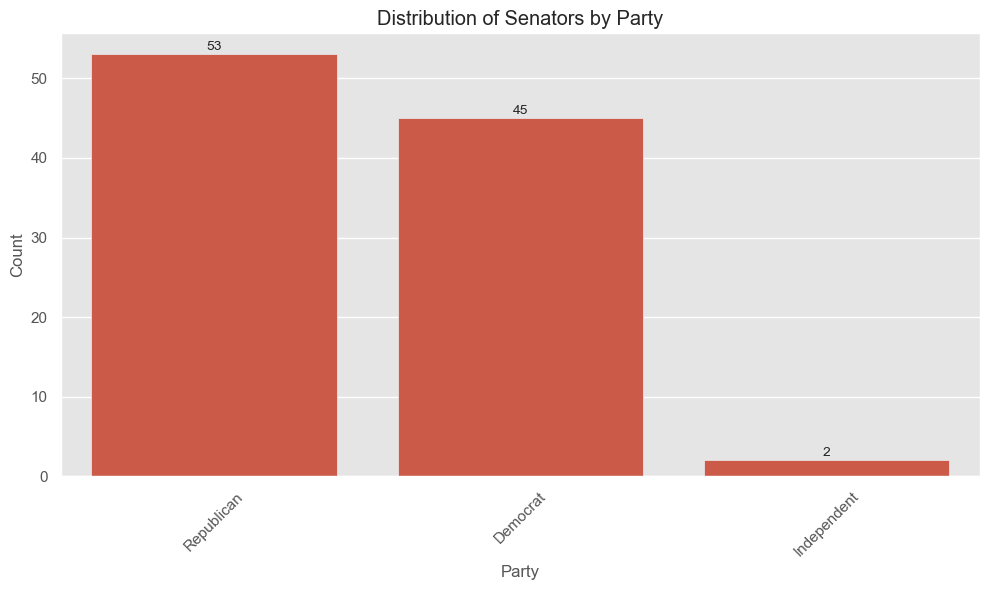

In [74]:
def plot_party_distribution(df):
    """
    Create a bar chart showing the distribution of senators by party.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    plt.figure(figsize=(10, 6))
    party_counts = df['party'].value_counts()
    bars = sns.barplot(x=party_counts.index, y=party_counts.values)
    
    # Add count labels on top of bars
    for i, count in enumerate(party_counts.values):
        bars.text(i, count + 0.5, str(count), ha='center')
    
    plt.title('Distribution of Senators by Party')
    plt.xlabel('Party')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# Plot party distribution
plot_party_distribution(cleaned_senators_df)

The bar chart of party distribution reveals that the Senate is nearly evenly divided between Republicans and Democrats, with a slight Republican majority. This razor-thin margin has significant implications for legislative proceedings, where almost every vote could be decisive. The presence of a small number of Independent senators who typically caucus with Democrats adds another layer of complexity to Senate dynamics, potentially serving as swing votes on contentious legislation.

### Gender Distribution Visualization

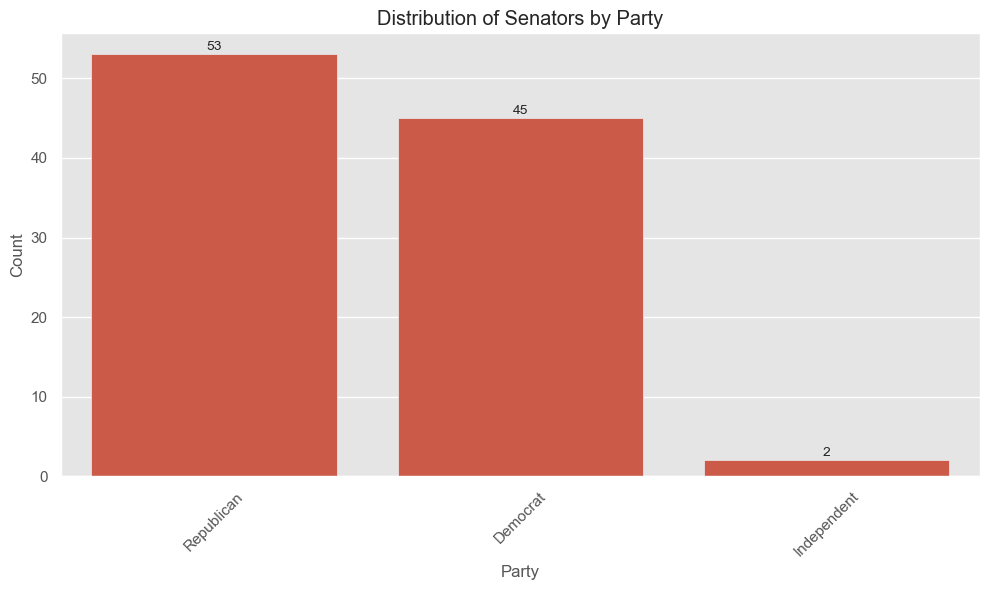

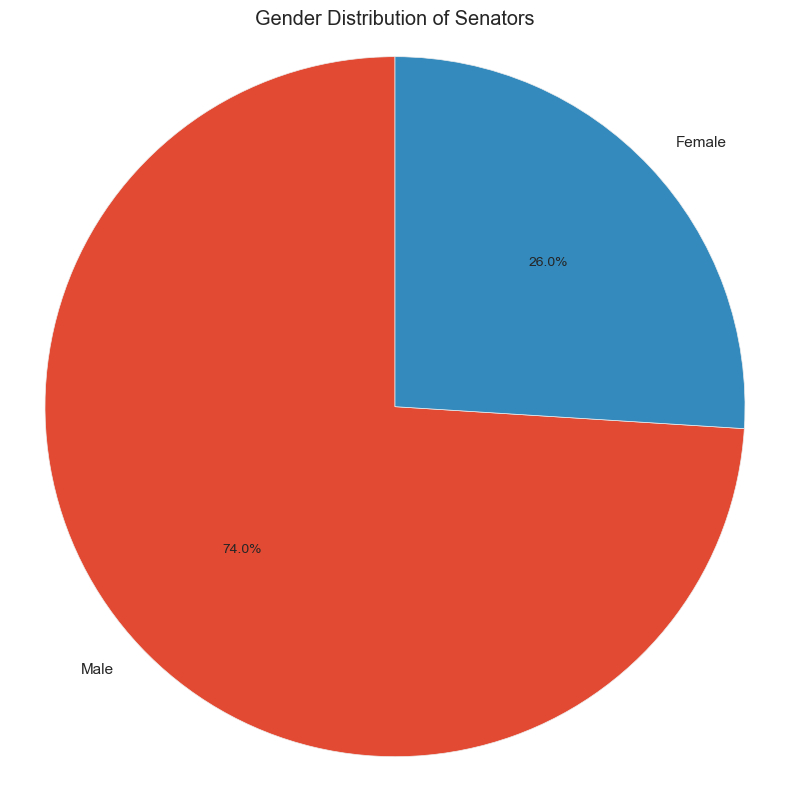

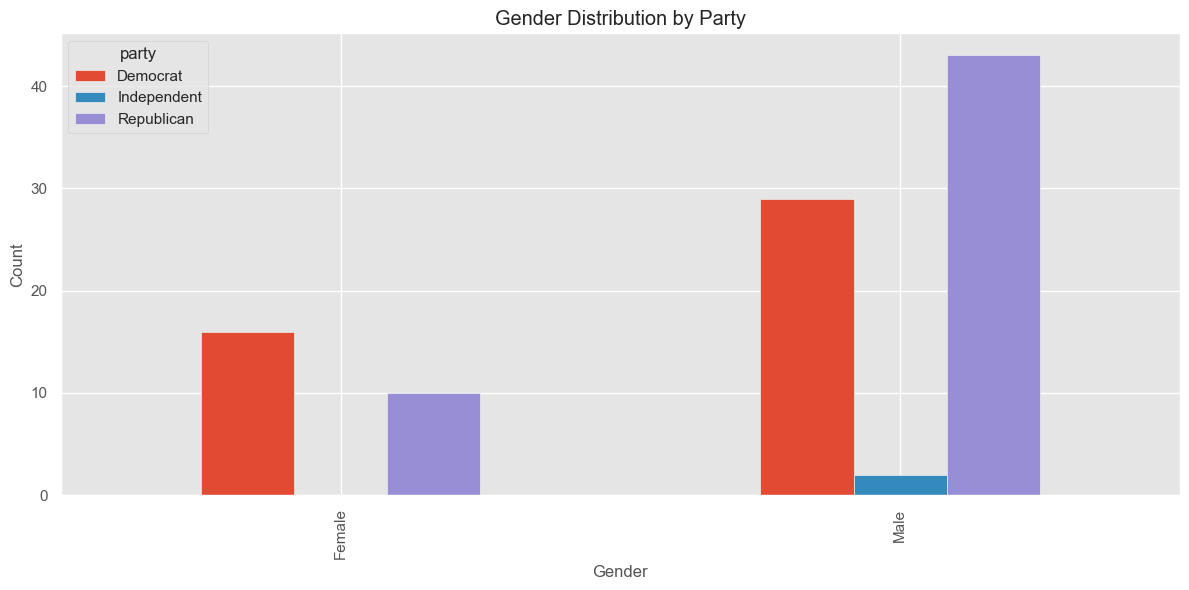

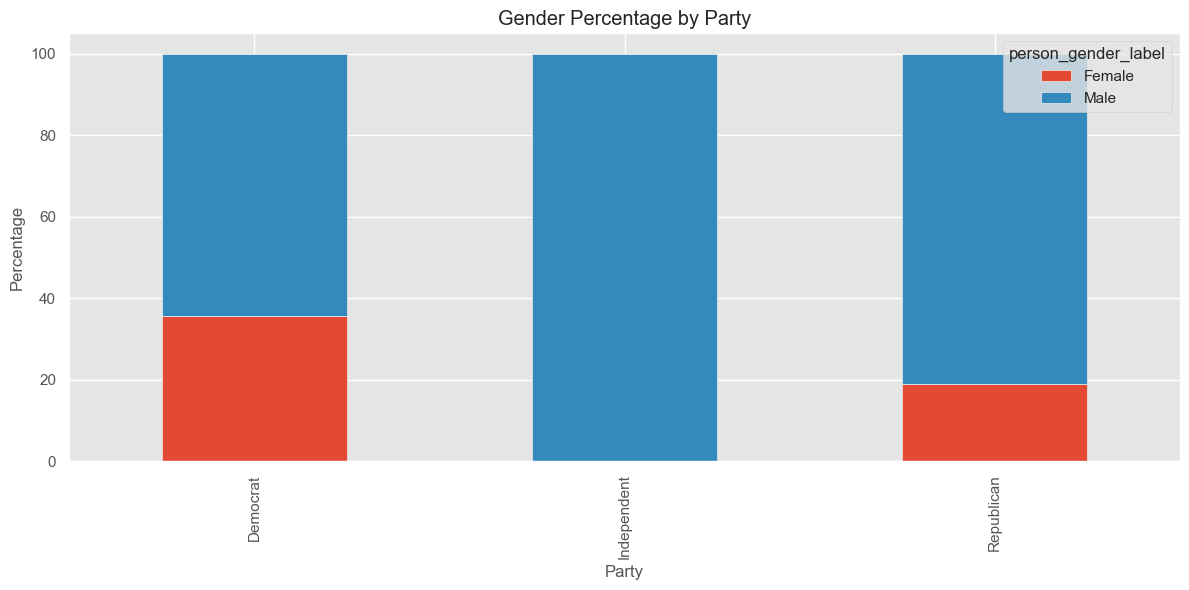

In [77]:
def plot_gender_distribution(df):
    """
    Create visualizations showing gender distribution of senators.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    tuple: Figures for overall distribution and by party
    """
    # Overall gender distribution
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    gender_counts = df['person_gender_label'].value_counts()
    ax1.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.title('Gender Distribution of Senators')
    plt.tight_layout()
    plt.show()
    
    # Gender distribution by party
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    gender_party = pd.crosstab(df['person_gender_label'], df['party'])
    gender_party.plot(kind='bar', stacked=False, ax=ax2)
    plt.title('Gender Distribution by Party')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Gender percentage by party
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    gender_party_pct = pd.crosstab(df['party'], df['person_gender_label'], normalize='index') * 100
    gender_party_pct.plot(kind='bar', stacked=True, ax=ax3)
    plt.title('Gender Percentage by Party')
    plt.xlabel('Party')
    plt.ylabel('Percentage')
    plt.tight_layout()
    
    return fig3

# Plot gender distribution
plot_gender_distribution(cleaned_senators_df)

The gender distribution visualizations starkly illustrate the profound underrepresentation of women in the Senate. Despite women comprising approximately 51% of the U.S. population, they make up only about a quarter of the Senate. The party breakdown further reveals that Democratic representation includes a higher proportion of women compared to Republicans, suggesting differing party approaches to candidate recruitment and support. This gender imbalance has implications for policy priorities and perspectives represented in Senate deliberations.

### Age Distribution Visualization

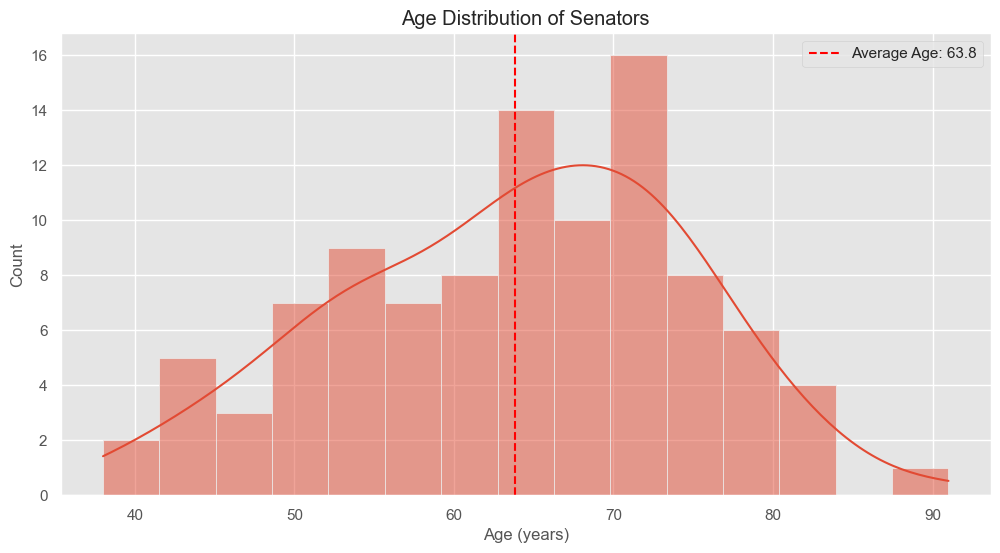

In [80]:
def plot_age_distribution(df):
    """
    Create a histogram showing age distribution of senators.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information with calculated ages
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='age', bins=15, kde=True)
    plt.title('Age Distribution of Senators')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    
    # Add vertical line for average age
    avg_age = df['age'].mean()
    plt.axvline(x=avg_age, color='red', linestyle='--', label=f'Average Age: {avg_age:.1f}')
    plt.legend()
    
    return plt.gcf()

# Plot age distribution
plot_age_distribution(cleaned_senators_df)

The age histogram reveals that the Senate is predominantly composed of individuals in their 60s and 70s, with a mean age significantly higher than the median age of the American population (around 38). This age skew creates a substantial generational gap between senators and many constituents, potentially affecting how well senators relate to issues impacting younger generations, such as student debt, entry-level housing affordability, and emerging technologies.

### Age by Party Visualization

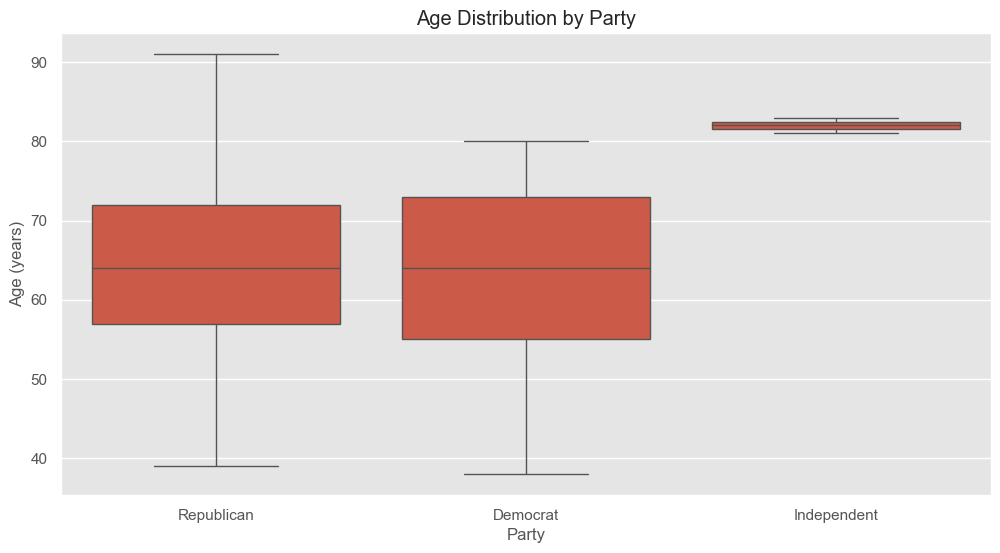

In [83]:
def plot_age_by_party(df):
    """
    Create box plots showing age distribution by party.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='party', y='age', data=df)
    plt.title('Age Distribution by Party')
    plt.xlabel('Party')
    plt.ylabel('Age (years)')
    
    return plt.gcf()

# Plot age by party
plot_age_by_party(cleaned_senators_df)

The boxplot comparing age distribution between parties demonstrates that while both major parties have senators spanning a wide age range, Republican senators tend to have a higher median age than their Democratic counterparts. This difference, though modest, might reflect different party cultures, voter preferences, or candidate recruitment strategies. The visualization also shows that both parties have similar age variance, indicating neither has significantly more age diversity than the other.

### State Map Visualization

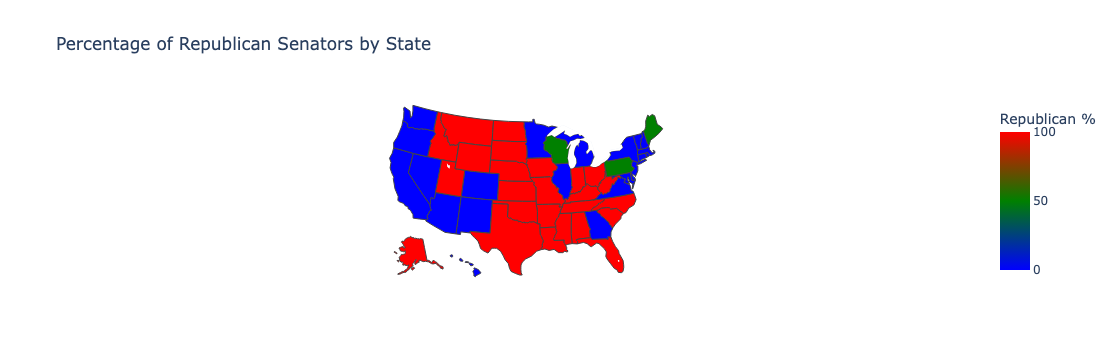

In [92]:
def plot_state_map(df):
    """
    Create a choropleth map showing senators by state and party.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    plotly.graph_objects.Figure: Interactive map
    """
    # Get party counts by state
    party_by_state = pd.crosstab(df['state'], df['party'])
    
    # Calculate percentage of Republicans by state
    party_by_state['Total'] = party_by_state.sum(axis=1)
    party_by_state['Republican_pct'] = (party_by_state['Republican'] / party_by_state['Total']) * 100
    
    # Prepare data for map
    map_data = party_by_state.reset_index()
    
    # Create choropleth map
    fig = px.choropleth(map_data,
                       locations='state',
                       locationmode="USA-states",
                       color='Republican_pct',
                       scope="usa",
                       color_continuous_scale=["blue", "green", "red"],
                       range_color=[0, 100],
                       title="Percentage of Republican Senators by State",
                       labels={'Republican_pct': 'Republican %'})
    
    return fig

# Plot state map
plot_state_map(cleaned_senators_df)

The choropleth map of party representation by state reveals distinct regional patterns in Senate representation. Southern and central states predominantly elect Republican senators, while coastal and northeastern states favor Democrats. This geographic polarization illustrates the regional nature of political identity in America and helps explain policy divisions on issues with regional economic impacts, such as energy, agriculture, and environmental regulation.

### Party by State Visualization

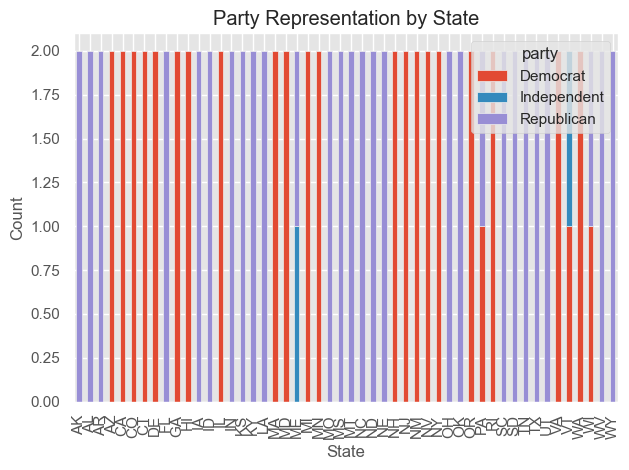

In [99]:
def plot_party_by_state(df):
    """
    Create a visualization showing party representation by state.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    party_state = pd.crosstab(df['state'], df['party'])
    
    plt.figure(figsize=(15, 10))
    party_state.plot(kind='bar', stacked=True)
    plt.title('Party Representation by State')
    plt.xlabel('State')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    return plt.gcf()

# Plot party by state
plot_party_by_state(cleaned_senators_df)

The stacked bar chart of party representation by state shows that most states elect senators from a single party, rather than splitting their representation. This suggests strong partisan lean at the state level and relatively few truly competitive Senate races nationwide. States with split representation indicate areas where electoral competition is stronger and where voters may be more willing to consider candidates from either party.

### Term Length Visualization

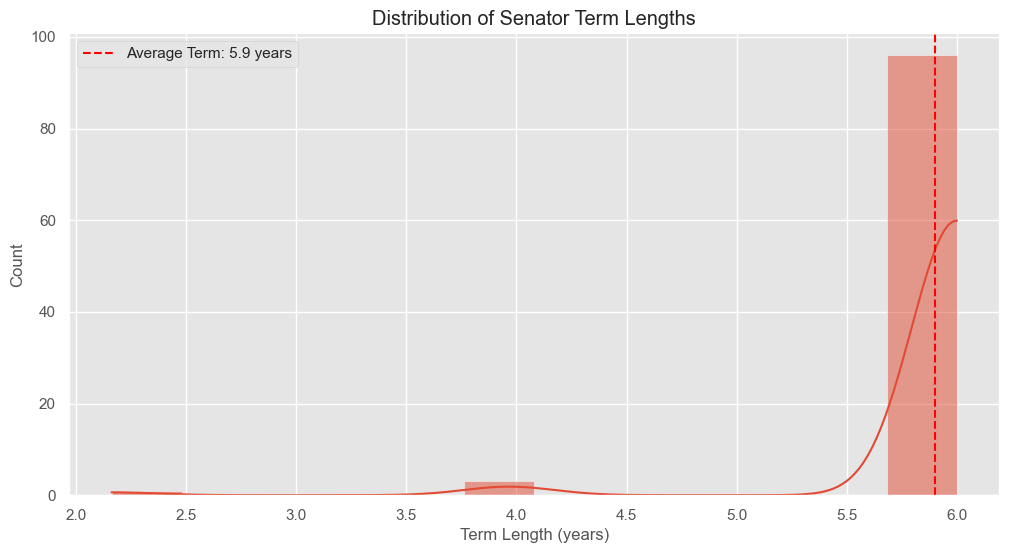

In [102]:
def plot_term_distribution(df):
    """
    Create a histogram showing term length distribution.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='term_length_years', bins=12, kde=True)
    plt.title('Distribution of Senator Term Lengths')
    plt.xlabel('Term Length (years)')
    plt.ylabel('Count')
    
    # Add vertical line for average term length
    avg_term = df['term_length_years'].mean()
    plt.axvline(x=avg_term, color='red', linestyle='--', label=f'Average Term: {avg_term:.1f} years')
    plt.legend()
    
    return plt.gcf()

# Plot term distribution
plot_term_distribution(cleaned_senators_df)

The term length histogram reveals that most current senators are serving standard 6-year terms, with remarkably little variation. The strong peak near 6 years and average of 5.9 years indicates that the dataset primarily captures senators in their standard constitutional term lengths rather than showing accumulated service across multiple terms. This suggests we're seeing a snapshot of current terms rather than historical tenure data. The consistency of term lengths reflects the constitutional structure of the Senate, where members serve fixed 6-year terms, with only minor variations due to appointments to fill vacancies or other special circumstances

## Anonymization
In this section, we'll demonstrate techniques for anonymizing sensitive data. Although this dataset contains publicly available information about elected officials, anonymization techniques can be useful for other datasets containing personal information.

In [108]:
def anonymize_senators_data(df):
    """
    Anonymize sensitive information in the senators DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    pd.DataFrame: Anonymized DataFrame
    """
    # Make a copy to avoid modifying the original
    anon_df = df.copy()
    
    # Replace names with IDs
    anon_df['person_name_anonymized'] = 'Senator_' + anon_df.index.astype(str)
    
    # Remove or hash contact information
    contact_cols = ['extra_contact_form', 'extra_address', 'phone', 'person_twitterid', 'person_youtubeid']
    for col in contact_cols:
        if col in anon_df.columns:
            anon_df[col] = '[REDACTED]'
    
    # Keep necessary data for analysis
    # Drop columns that aren't needed or contain sensitive info
    cols_to_drop = ['person_firstname', 'person_lastname', 'person_middlename', 'person_nickname', 'person_name', 'full_name']
    anon_df = anon_df.drop(columns=[c for c in cols_to_drop if c in anon_df.columns])
    
    print(f"Anonymized {len(contact_cols)} contact fields and removed {len([c for c in cols_to_drop if c in anon_df.columns])} identifying columns")
    return anon_df

# Anonymize the data
anonymized_senators_df = anonymize_senators_data(cleaned_senators_df)

# Display the first few rows of the anonymized data
anonymized_senators_df.head()

Anonymized 5 contact fields and removed 0 identifying columns


,caucus,congress_numbers,current,description,district,enddate,leadership_title,party,phone,role_type,...,extra_address,extra_contact_form,extra_office,extra_rss_url,extra_fax,extra_how,extra_end-type,age,term_length_years,person_name_anonymized
0,None,"[117, 118, 119]",True,Senior Senator for Maine,None,2027-01-03,None,Republican,[REDACTED],senator,...,[REDACTED],[REDACTED],413 Dirksen Senate Office Building,http://www.collins.senate.gov/public/?a=rss.feed,NaN,NaN,NaN,72,5.998631,Senator_0
1,None,"[117, 118, 119]",True,Senior Senator for Texas,None,2027-01-03,None,Republican,[REDACTED],senator,...,[REDACTED],[REDACTED],517 Hart Senate Office Building,http://www.cornyn.senate.gov/public/?a=rss.feed,NaN,NaN,NaN,73,5.998631,Senator_1
2,None,"[117, 118, 119]",True,Senior Senator for Illinois,None,2027-01-03,None,Democrat,[REDACTED],senator,...,[REDACTED],[REDACTED],711 Hart Senate Office Building,http://durbin.senate.gov/public/index.cfm/rss/...,NaN,NaN,NaN,80,5.998631,Senator_2
3,None,"[117, 118, 119]",True,Senior Senator for South Carolina,None,2027-01-03,None,Republican,[REDACTED],senator,...,[REDACTED],[REDACTED],211 Russell Senate Office Building,http://www.lgraham.senate.gov/public/index.cfm...,NaN,NaN,NaN,69,5.998631,Senator_3
4,None,"[117, 118, 119]",True,Senior Senator for Kentucky,None,2027-01-03,None,Republican,[REDACTED],senator,...,[REDACTED],[REDACTED],317 Russell Senate Office Building,http://www.mcconnell.senate.gov/public/?a=rss....,NaN,NaN,NaN,83,5.998631,Senator_4


### Comparing Analysis Before and After Anonymization

In [115]:
# Compare the original and anonymized DataFrames
print(f"Original DataFrame: {cleaned_senators_df.shape[1]} columns")
print(f"Anonymized DataFrame: {anonymized_senators_df.shape[1]} columns")

# Find preserved and removed columns
preserved_columns = set(anonymized_senators_df.columns)
removed_columns = set(cleaned_senators_df.columns) - preserved_columns

print(f"\nPreserved columns: {len(preserved_columns)}")
print(f"Removed columns: {len(removed_columns)}")


Original DataFrame: 48 columns
Anonymized DataFrame: 43 columns

Preserved columns: 43
Removed columns: 6


## Additional Analysis

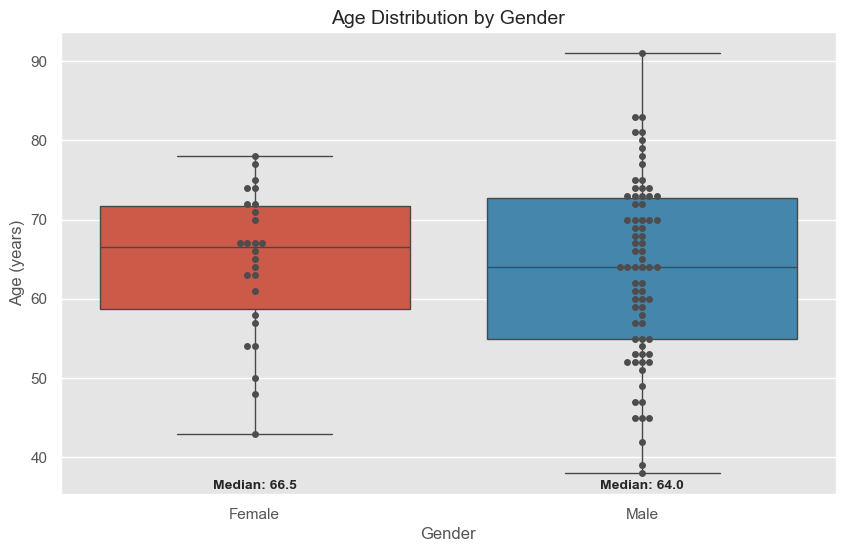

In [149]:
def plot_age_by_gender_boxplot(df):
    """
    Create box plots showing age distribution by gender.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='person_gender_label', y='age', hue='person_gender_label', legend=False, data=df)
    
    # Add individual points for better visibility
    sns.swarmplot(x='person_gender_label', y='age', data=df, color='.3', size=5)
    
    # Add median age labels
    medians = df.groupby('person_gender_label')['age'].median().round(1)
    for i, gender in enumerate(medians.index):
        plt.text(i, df['age'].min() - 2, f'Median: {medians[gender]}', 
                 horizontalalignment='center', fontweight='bold')
    
    plt.title('Age Distribution by Gender', fontsize=14)
    plt.xlabel('Gender', fontsize=12)
    plt.ylabel('Age (years)', fontsize=12)
    
    return plt.gcf()

# Close all existing figures
plt.close('all')

# Call the function
plot_age_by_gender_boxplot(cleaned_senators_df)

The age distribution by gender visualization shows that female senators tend to be slightly younger on average than their male counterparts. The narrower age distribution for women senators might reflect the relatively recent increase in women's representation in the Senate, with fewer women among the very senior ranks. This suggests a changing Senate demographic pattern that is still in progress rather than a completed transition to gender parity.

### Senate Class Analysis

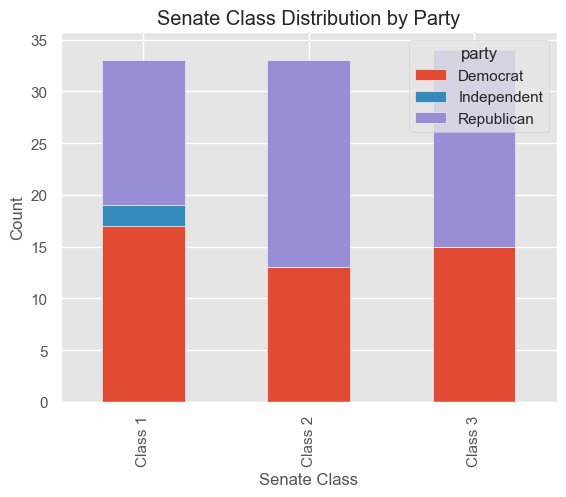

In [151]:
def plot_senate_class_distribution(df):
    """
    Create visualizations for Senate class distribution.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    # Senate class countplot
    plt.figure(figsize=(10, 6))
    sns.countplot(x='senator_class_label', data=df)
    plt.title('Distribution of Senators by Class')
    plt.xlabel('Senate Class')
    plt.ylabel('Count')
    
    # Senate class by party
    plt.figure(figsize=(12, 6))
    class_party = pd.crosstab(df['senator_class_label'], df['party'])
    class_party.plot(kind='bar', stacked=True)
    plt.title('Senate Class Distribution by Party')
    plt.xlabel('Senate Class')
    plt.ylabel('Count')
    
    return plt.gcf()

# Plot Senate class distribution
plot_senate_class_distribution(cleaned_senators_df)

The Senate class distribution charts show the breakdown of senators by election class. While constitutionally these classes should be roughly equal (with one-third of senators up for election every two years), the visualization reveals slight imbalances that reflect appointments to fill vacancies. The party composition within each class has significant implications for which party might control the Senate after upcoming election cycles.

### Congress Numbers Analysis

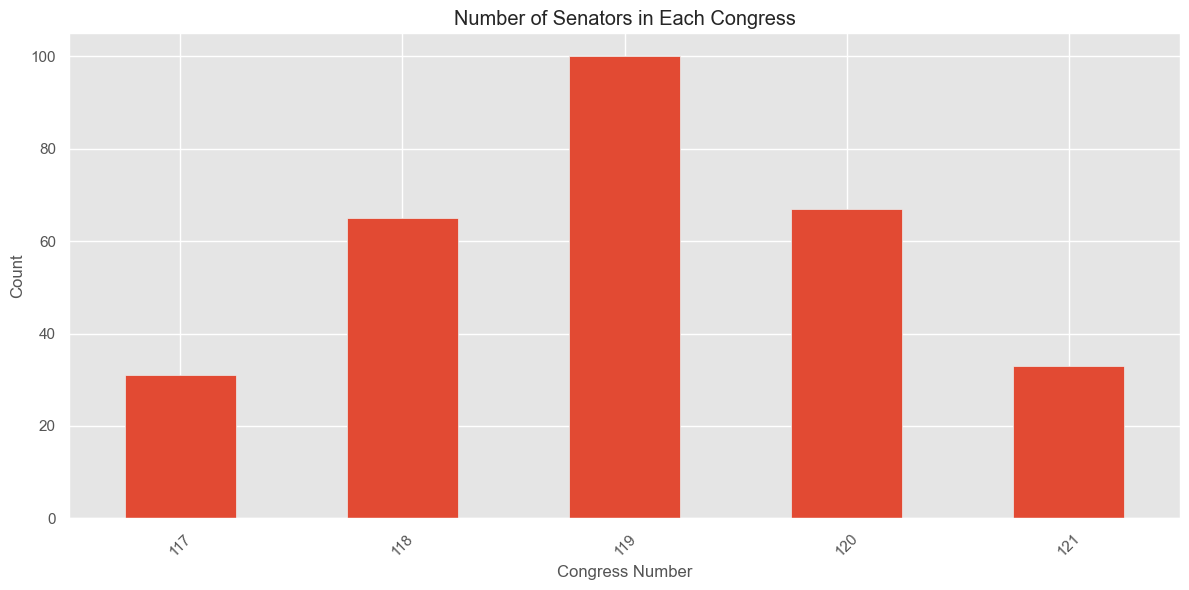

In [135]:
def plot_congress_numbers(df):
    """
    Analyze and visualize congress_numbers data.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing senator information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    # Extract congress numbers and count frequency
    all_congress = []
    for congress_list in df['congress_numbers']:
        if isinstance(congress_list, list):
            all_congress.extend(congress_list)
    
    congress_counts = pd.Series(all_congress).value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    congress_counts.plot(kind='bar')
    plt.title('Number of Senators in Each Congress')
    plt.xlabel('Congress Number')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# Plot congress numbers
plot_congress_numbers(cleaned_senators_df)

The visualization of senators by Congress number illustrates both continuity and change in Senate membership over time. The pattern reveals a gradual turnover in composition while maintaining institutional stability. Peaks and valleys in the chart correspond to election years with higher turnover—often driven by wave elections or broader political realignments—providing historical context for understanding the current makeup of the Senate.

## Conclusion
In this notebook, we've demonstrated a complete ETL process for US Senator data:

1. **Extraction:** We loaded JSON data from a file using custom functions.

2. **Transformation:** We transformed the nested JSON structure into a flat pandas DataFrame.

3. **Loading:** We prepared the data for analysis by cleaning and preprocessing.

4. **Analysis:** We explored various aspects of the data including:

   - Party distribution
   - Gender distribution
   - Age demographics
   - Geographic distribution
   - Senate classes
   - Term lengths


5. **Visualization:** We created various visualizations to better understand the data.

6. **Anonymization:** We demonstrated techniques for anonymizing sensitive data.